In [1]:
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/GaussFit_spec2D.py
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/ChainTool.py

%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np

dir_tfCube: /Users/hhg/Research/kinematic_lensing/repo/KLens


In [2]:
sys.path.append("/Users/hhg/Research/kinematic_lensing/code/BinnedFit/")
from binnedFit_utilities import *

In [3]:
TF_pars = load_pickle("/Users/hhg/Research/kinematic_lensing/data/TF_pars.pickle")
meta_parameters = ("/Users/hhg/Research/kinematic_lensing/data/meta_parameters.pickle")

data = load_pickle("/Users/hhg/Research/kinematic_lensing/data/data.pickle")
noise = load_pickle("/Users/hhg/Research/kinematic_lensing/data/noise.pickle")
obslambda = np.load("/Users/hhg/Research/kinematic_lensing/data/obslambda.npy")

In [4]:
TF_pars

{'g1': 0.05,
 'g2': 0.0,
 'sini': 0.8,
 'diskFrac': 1.0,
 'n_knots': 25.0,
 'knot_fraction': 0.0,
 'aspect': 0.2,
 'vcirc': 200.0,
 'sigma_intr': 0.01,
 'redshift': 0.2,
 'half_light_radius': 0.5,
 'vscale': 0.5,
 'r_0': 0.0,
 'V_0': 0.0,
 'linelist': array([('OIIa', 372.7092, 2.e-25), ('OIIb', 372.9875, 2.e-25),
        ('OIIIa', 496.0295, 2.e-25), ('OIIIb', 500.824 , 2.e-25),
        ('Halpha', 656.461 , 6.e-24)],
       dtype=[('species', '<U16'), ('lambda', '<f8'), ('flux', '<f8')]),
 'norm': 0.0,
 'abs_magnitude': None,
 'image_size': 128,
 'ngrid': 256,
 'psfFWHM': 0.5,
 'psf_g1': 0.0,
 'psf_g2': 0.0,
 'area': 785000.0,
 'pixScale': 0.1185,
 'Resolution': 6000.0,
 'lambda_min': array([785.7532]),
 'lambda_max': array([789.7532]),
 'nm_per_pixel': 0.033,
 'gain': 1.0,
 'read_noise': 3.0,
 'throughput': 0.29,
 'expTime': 3600.0,
 'type_of_observation': 'slit',
 'fiber_size': 1.0,
 'fiber_offsets': [[0.0, 0.0],
  [1.0, 0.0],
  [-1.0, 0.0],
  [0.0, 1.0],
  [1.0, 1.0]],
 'slitAngles':

In [5]:
# make data_info from Prangal's data output

data_info = {}
data_info['ModelCube'] = None
data_info['ObsCube'] = None
data_info['image'] = data['image']
data_info['image_variance'] = noise['image']

if len(TF_pars['slitAngles']) == 1:
    data_info['data'] = data['spectra'][0]
else:
    data_info['data_list'] = data['spectra']
    
data_info['grid_lambda'] = obslambda

extent =  TF_pars['image_size'] * TF_pars['pixScale']
subGridPixScale = extent*1./TF_pars['ngrid']

data_info['grid_pos']  = np.arange(-extent/2., extent/2., subGridPixScale)
data_info['grid_Image'] = np.arange(-extent/2., extent/2., TF_pars['pixScale'])
data_info['par_fid']   = TF_pars
data_info['lambda_emit'] = 656.461 # Halpha [nm]

In [6]:
data_info['grid_pos'].shape

(256,)

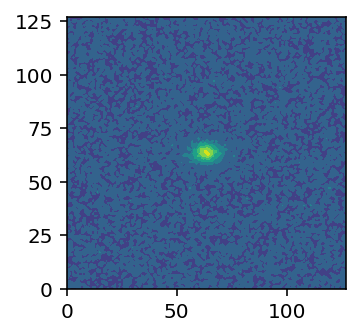

In [7]:
# check image
fig, ax = plt.subplots(1,1, figsize=(2.5,2.5))
ax.contourf(data_info['image'])

# Image 

In [8]:
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/ImageFit.py

In [9]:
ImageFit = ImageFit(data_info=data_info)

In [10]:
# check : data model consistency 
model_image = ImageFit.model_image(e_obs=1, half_light_radius=0.5)

print("data signal", ImageFit.image[63,63])
print("model signal", model_image[63,63])

data signal 0.008891687
model signal 0.00983775


In [11]:
chainImage_info = ImageFit.run_MCMC(Nwalker=50, Nsteps=1000)

100%|██████████| 1000/1000 [00:52<00:00, 18.91it/s]

Total MCMC time (mins): 0.8822364807128906


In [12]:
Chain_Image = ChainTool(chainImage_info, Nburn=30000, Nend=50000)

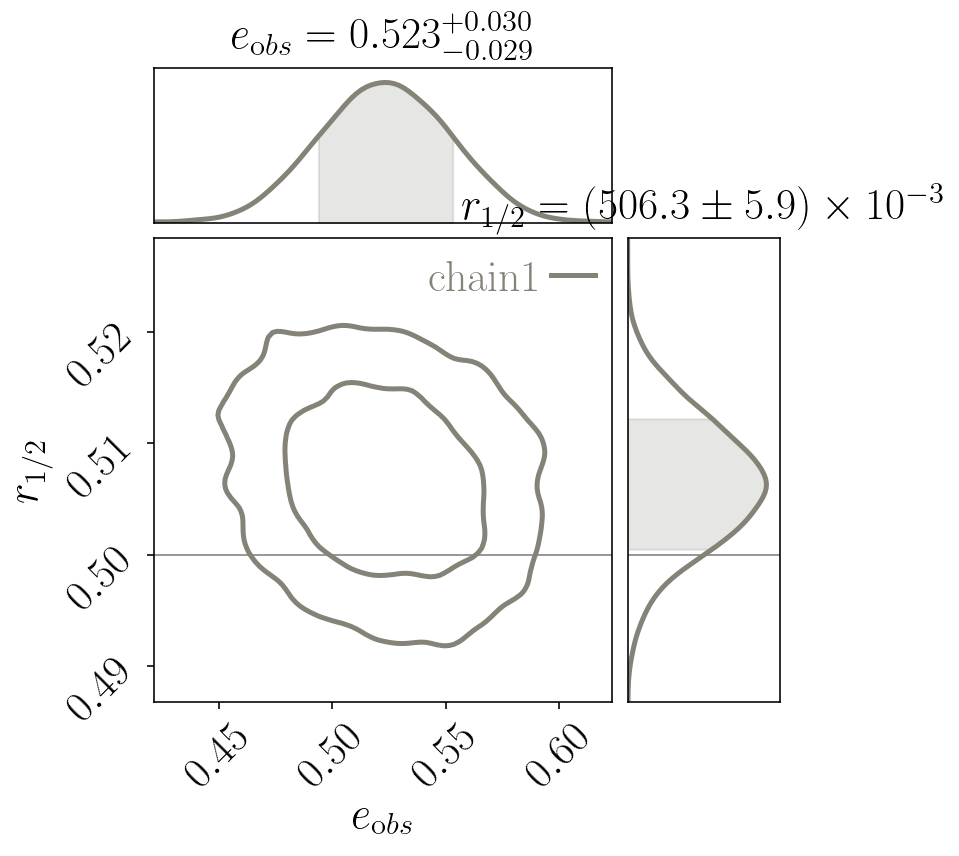

In [13]:
Nchains = 1
colors = [gray, lightblue, red, yellow, blue, yellowgreen, green, green, black]
lines = ["-", '--', "--", "-.", '-', ":", "--", ':']

statistics="max"

select_par_key = ['e_obs','half_light_radius']

parID1,parName1,par_x1 = Chain_Image.select_par_info(select_par_key)

c = ChainConsumer()
c.add_chain(Chain_Image.chain[:, parID1], parameters=parName1 ,name="$\mathrm{chain1}$")


c.configure(linewidths=2.5,sigmas=np.array([0,1,2]),bins=0.5,sigma2d=False,label_font_size=22,tick_font_size=22
            ,colors=colors
            ,shade=[False]*Nchains
            ,statistics=statistics,summary=True
            ,linestyles=lines
            ,shade_gradient=[0]*Nchains
            ,bar_shade=[True]*Nchains)


c.configure_truth(color="gray",lw=1,ls="-",alpha=0.8, zorder=-1)
fig = c.plotter.plot(legend=True, truth=[None,0.5]) #, truth=par_x1

fig.subplots_adjust(left=0.12, right=0.99, bottom=0.11, top=0.99)

fig.set_size_inches(2 + fig.get_size_inches())
fig.savefig("fig1.pdf", transparent=True)

In [14]:
bestfit_e_obs = Chain_Image.par_bestfit(select_par_key=['e_obs'], statistics='max')['e_obs'][1]
bestfit_e_obs

0.5248507943155322

# 2D spectrum

In [15]:
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/RotationCurveFit.py

In [16]:
# init Fit tool
RotFit = RotationCurveFit(data_info, active_par_key = ['vscale','vcirc','sini'], e_obs=bestfit_e_obs)

time cost in gaussFit_spec2D: 0.14912199974060059 (secs)


In [17]:
# find fitting parameter using optimizer
params_rot = RotFit.optFit_rotation_curve(RotFit.gaussfit_peakLambda, par_init_guess={'vscale':0.5, 'vcirc':200, 'sini':0.5})
params_rot

{'vscale': 0.5038353148746896,
 'r_0': -9.999999999999999e-09,
 'vcirc': 286.369133846256,
 'v_0': -2.3583115643262938e-26,
 'redshift': 0.19999999999999998,
 'sini': 0.5595522892192984}

In [18]:
# find fitting parameters using MCMC (get error bars as well)
chain_info = RotFit.run_MCMC(Nwalker=100, Nsteps=3000)

/Users/hhg/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 3000/3000 [00:12<00:00, 240.34it/s]

Total MCMC time (mins): 0.20820461511611937


In [19]:
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/ChainTool.py
Chain = ChainTool(chain_info, Nburn=150000, Nend=300000)

In [20]:
Chain.chain.shape

(150000, 6)

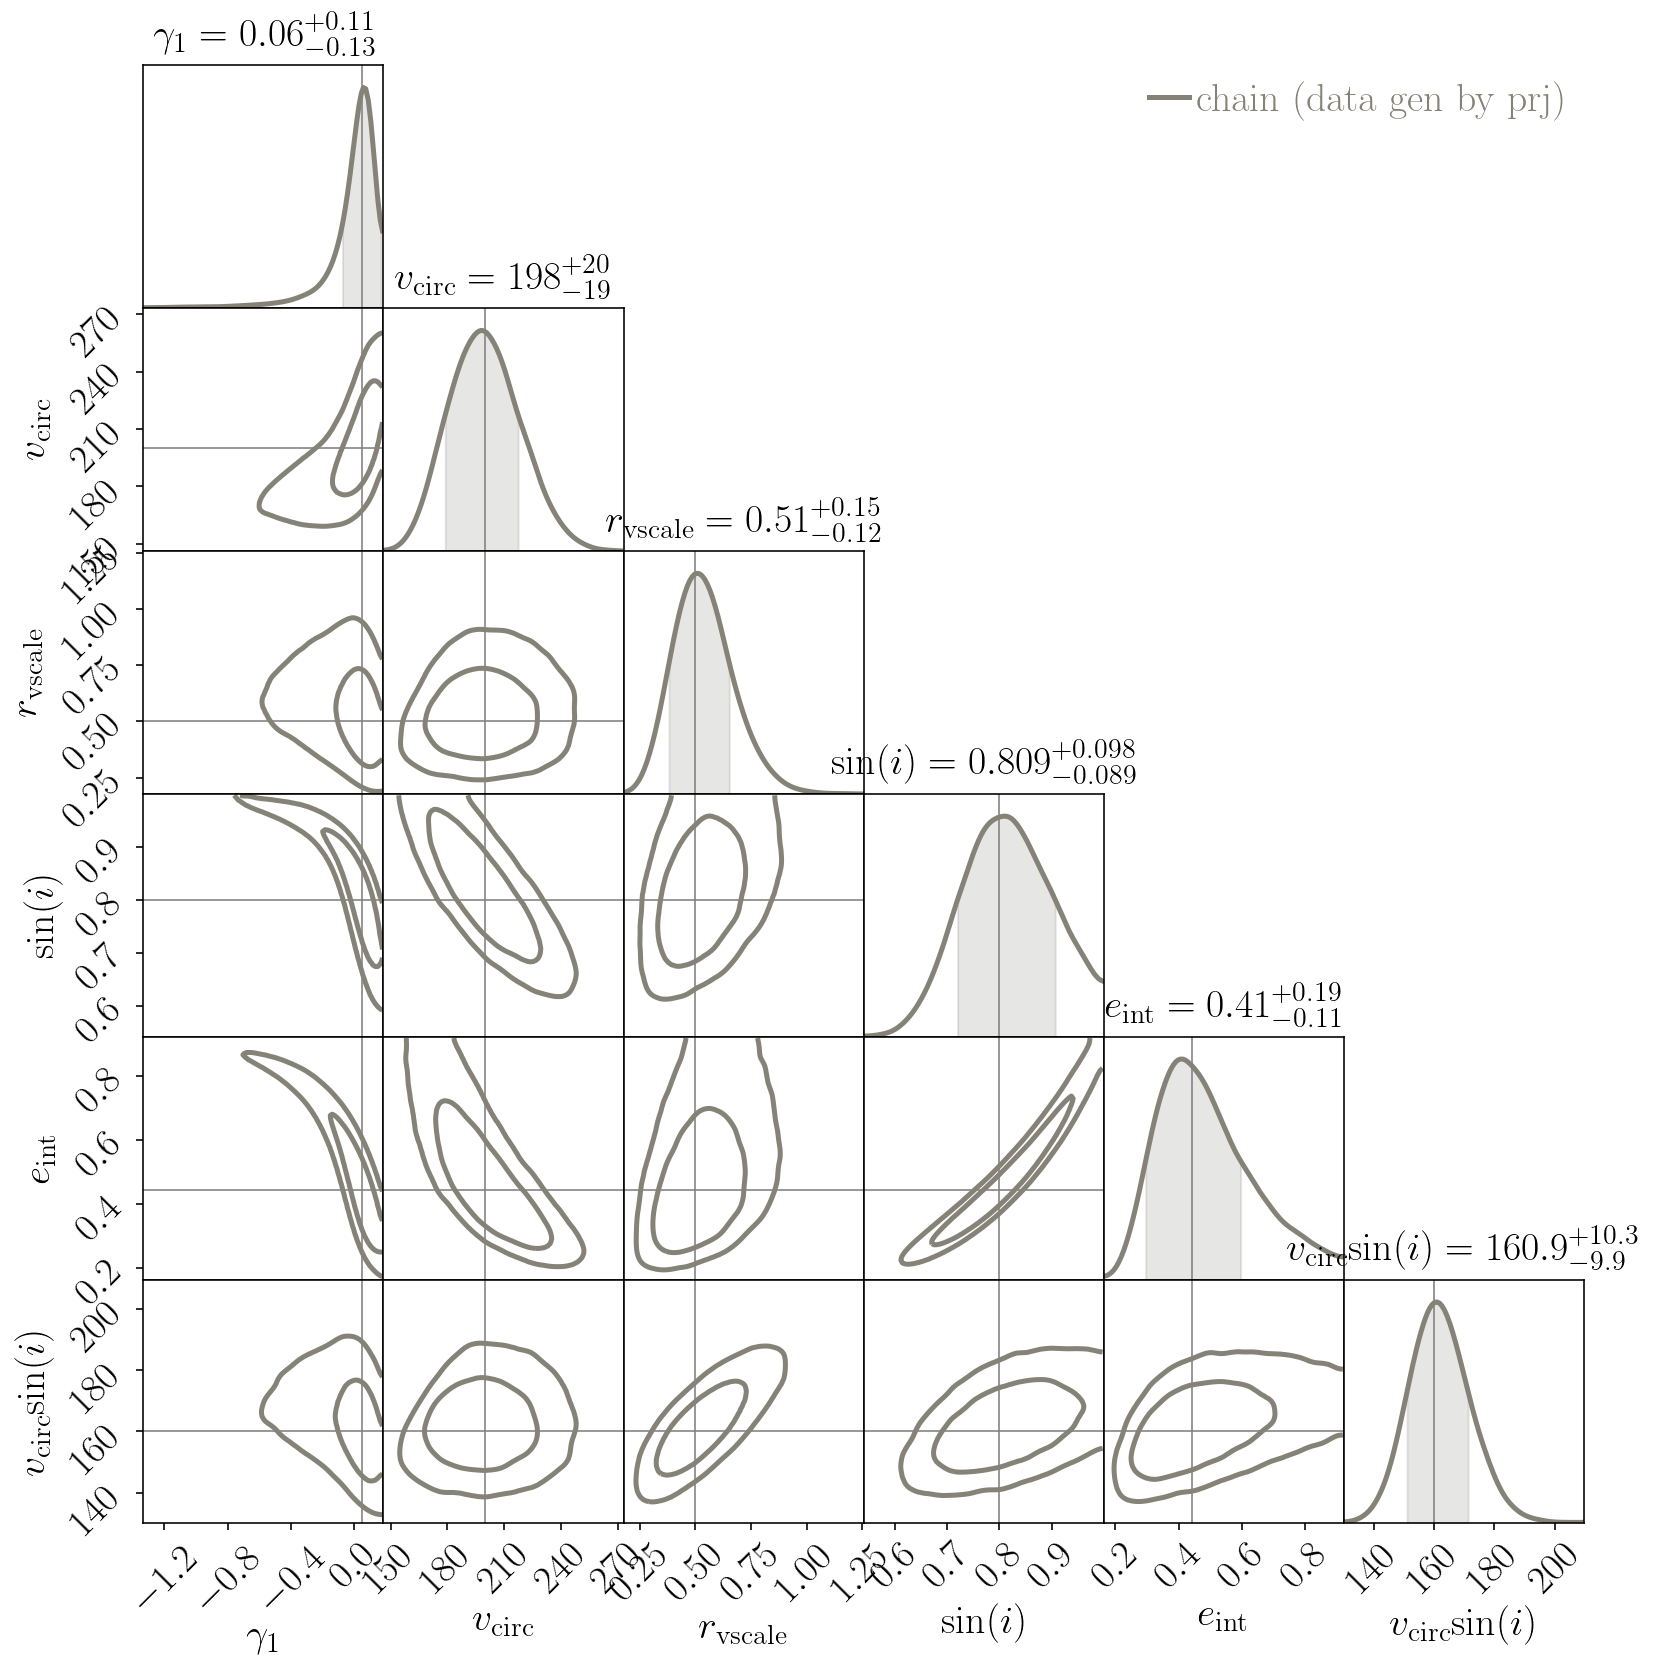

In [21]:
Nchains = 1
colors = [gray, lightblue, red, yellow, blue, yellowgreen, green, green, black]
lines = ["-", '--', "--", "-.", '-', ":", "--", ':']

statistics="max"

select_par_key = ['g1','vcirc','vscale','sini','e_int','vsini']

parID1,parName1,par_x1 = Chain.select_par_info(select_par_key)

c = ChainConsumer()
c.add_chain(Chain.chain[:, parID1]       , parameters=parName1 ,name="$\mathrm{chain\ (data\ gen\ by\ prj)}$")

c.configure(linewidths=2.5,sigmas=np.array([0,1,2]),bins=0.5,sigma2d=False,label_font_size=20,tick_font_size=20
            ,colors=colors
            ,shade=[False]*Nchains
            ,statistics=statistics,summary=True
            ,linestyles=lines
            ,shade_gradient=[0]*Nchains
            ,bar_shade=[True]*Nchains)


c.configure_truth(color="gray",lw=1,ls="-",alpha=0.8, zorder=-1)
fig = c.plotter.plot(legend=True, truth=par_x1)

fig.subplots_adjust(left=0.12, right=0.99, bottom=0.11, top=0.99)

fig.set_size_inches(2.5 + fig.get_size_inches())
fig.savefig("fig1.pdf", transparent=True)

In [22]:
samples_prj = np.load("/Users/hhg/Research/kinematic_lensing/data/samples_prj.npy")

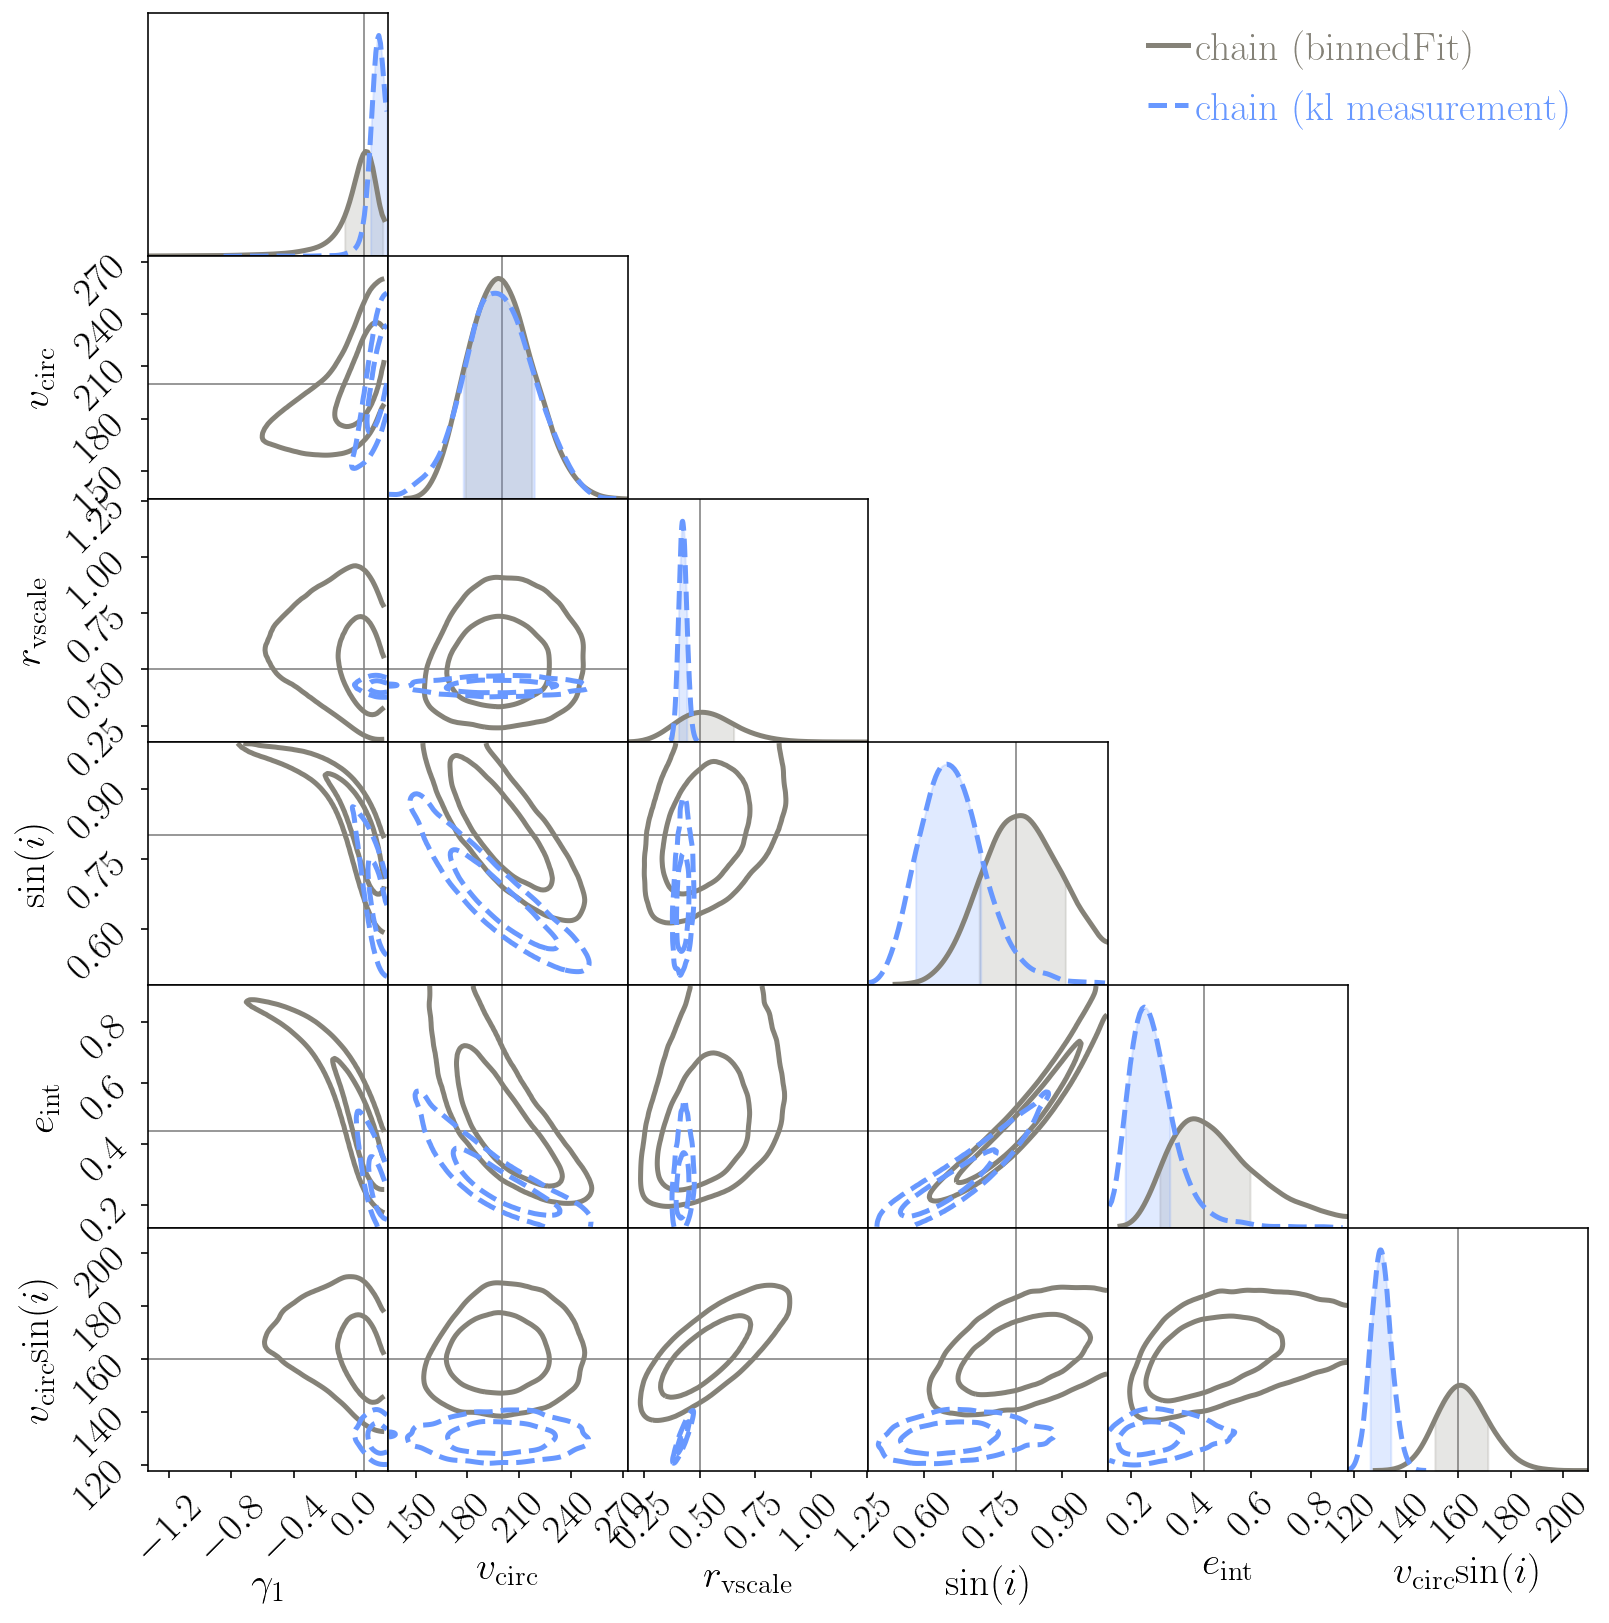

In [23]:
Nchains = 2
colors = [gray, lightblue, red, yellow, blue, yellowgreen, green, green, black]
lines = ["-", '--', "--", "-.", '-', ":", "--", ':']

statistics="max"

select_par_key = ['g1','vcirc','vscale','sini','e_int','vsini']

parID1,parName1,par_x1 = Chain.select_par_info(select_par_key)

c = ChainConsumer()
c.add_chain(Chain.chain[:, parID1], parameters=parName1 ,name="$\mathrm{chain\ (binnedFit)}$")
c.add_chain(samples_prj           , parameters=parName1 ,name="$\mathrm{chain\ (kl\ measurement)}$")


c.configure(linewidths=2.5,sigmas=np.array([0,1,2]),bins=0.5,sigma2d=False,label_font_size=20,tick_font_size=20
            ,colors=colors
            ,shade=[False]*Nchains
            ,statistics=statistics,summary=True
            ,linestyles=lines
            ,shade_gradient=[0]*Nchains
            ,bar_shade=[True]*Nchains)


c.configure_truth(color="gray",lw=1,ls="-",alpha=0.8, zorder=-1)
fig = c.plotter.plot(legend=True, truth=par_x1)

fig.subplots_adjust(left=0.12, right=0.99, bottom=0.11, top=0.99)

fig.set_size_inches(2.5 + fig.get_size_inches())
fig.savefig("fig1.pdf", transparent=True)

## Plot spectrum

In [24]:
GaussFit = GaussFit_spec2D(data_info)

In [25]:
fitted_peakLambda, fitted_amp, fitted_sigma = GaussFit.gaussFit_spec2D(data=GaussFit.data)

model = GaussFit.model_spec2D(fitted_peakLambda,fitted_amp,fitted_sigma)

data = GaussFit.data

time cost in gaussFit_spec2D: 0.16459012031555176 (secs)


In [26]:
lambda_min = np.min(GaussFit.grid_lambda)  ; lambda_MAX = np.max(GaussFit.grid_lambda)
x_min = np.min(GaussFit.grid_pos)          ; x_MAX = np.max(GaussFit.grid_pos)

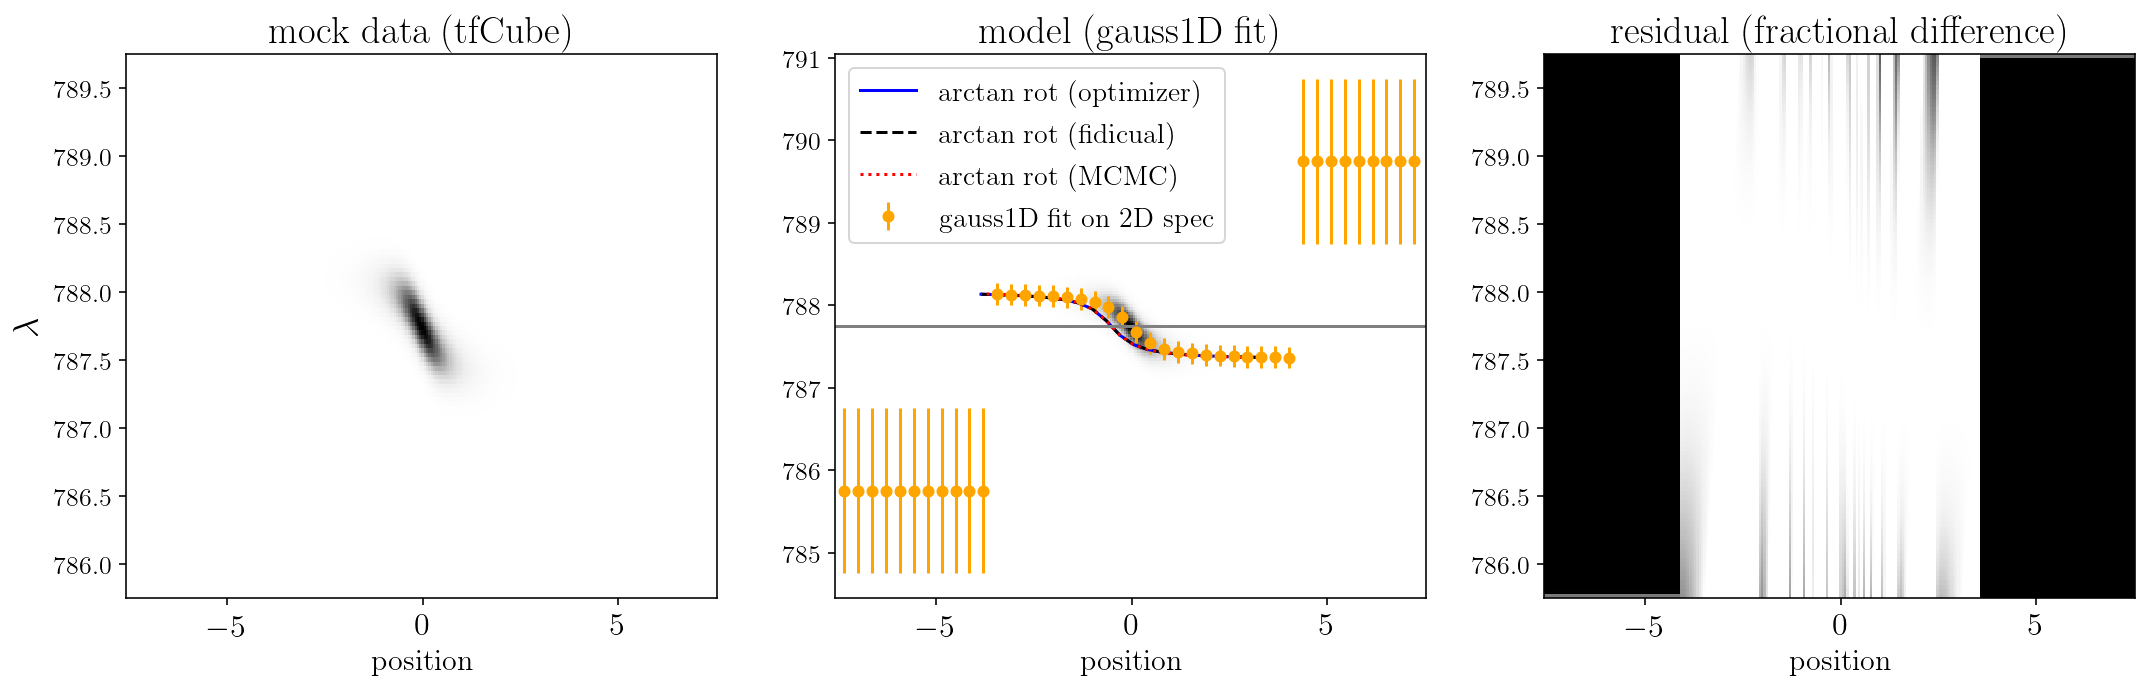

In [27]:
#%matplotlib
%matplotlib inline

ncol=3

fig,ax = plt.subplots(1,ncol,figsize=(18,5))
plt.rc('font',size=16)

ax[0].imshow(data.T ,extent=[x_min, x_MAX, lambda_min, lambda_MAX ]       , aspect='auto',cmap='Greys',vmin=0)
ax[1].imshow(model.T,extent=[x_min, x_MAX, lambda_min, lambda_MAX ]       , aspect='auto',cmap='Greys',vmin=0)
ax[2].imshow((data.T-model.T)/data.T,extent=[x_min, x_MAX, lambda_min, lambda_MAX ], aspect='auto',cmap='Greys',vmin=0)

ax[1].errorbar(np.flip(GaussFit.grid_pos)[5::6], fitted_peakLambda[5::6], fitted_sigma[5::6] ,color='orange', marker='o', markersize=5,ls='none',label='gauss1D fit on 2D spec')
#ax[1].errorbar(np.flip(RotFit.grid_pos)[3::7], RotFit.gaussfit_peakLambda[3::7], RotFit.gaussfit_sigma[3::7] ,color='orange', marker='o', markersize=5,ls='none',label='gauss1D fit on 2D spec')
ax[1].plot(np.flip(RotFit.grid_pos)[5::6],RotFit.fitted_rot_lambdaObs[5::6],color='b',ls='-',label='arctan rot (optimizer)')


par = RotFit.Parameter.par_fid.copy()
fidicual_rot = RotFit.model_arctan_rotation(RotFit.grid_pos, vscale=par['vscale'], r_0=par['r_0'], vcirc=par['vcirc'], v_0=par['v_0'], redshift=par['redshift'], sini=par['sini'])
ax[1].plot(np.flip(RotFit.grid_pos)[5::6],fidicual_rot[5::6],color='k',ls='--',label='arctan rot (fidicual)')


par_bestfit_MC = Chain.par_bestfit(select_par_key=None, statistics='max', mode=0)
MC_rot = RotFit.model_arctan_rotation(RotFit.grid_pos, vscale=par_bestfit_MC['vscale'][1], r_0=par['r_0'], vcirc=par_bestfit_MC['vcirc'][1], v_0=par['v_0'], redshift=par['redshift'], sini=par_bestfit_MC['sini'][1])
ax[1].plot(np.flip(RotFit.grid_pos)[5::6],MC_rot[5::6],color='r',ls=':',label='arctan rot (MCMC)')


lambda_cen = data_info['lambda_emit']*(1.+data_info['par_fid']['redshift'])

ax[1].axhline(lambda_cen, color='gray')

for j in range(ncol):
    #ax[j].set_ylim(vcen-1.5,vcen+1.5)
    #ax[j].set_xlim(-3.5,3.5)
    ax[j].set_xlabel('position', fontsize=15)
    ax[j].tick_params(axis='x', labelsize=16)
    ax[j].tick_params(axis='y', labelsize=13)

ax[0].set_ylabel(r'$\lambda$', fontsize=18)    
ax[0].set_title('mock data (tfCube)')
ax[1].set_title('model (gauss1D fit)')
ax[2].set_title('residual (fractional difference)')

#ax[1].legend(loc=(2.3,0.75),prop={'size':16})
ax[1].legend(loc="best",prop={'size':14})

plt.show()

Text(0, 0.5, 'arcmin')

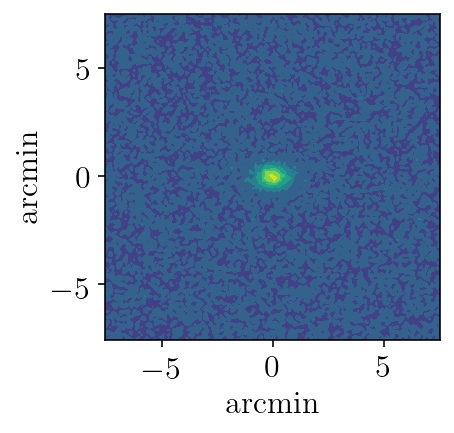

In [28]:
# check image
fig, ax = plt.subplots(1,1, figsize=(3.,3.))
ax.contourf(data_info['image'] ,extent=[x_min, x_MAX, x_min, x_MAX])

ax.set_xlabel('arcmin')
ax.set_ylabel('arcmin')

# ---- END ----

In [29]:
import emcee
import numpy as np

def log_prior(params):
    return -0.5 * np.sum(params**2)

def log_like(params):
    return -0.5 * np.sum((params / 0.1)**2)

def log_prob(params):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf, -np.inf
    ll = log_like(params)
    if not np.isfinite(ll):
        return lp, -np.inf
    return lp + ll, lp

coords = np.random.randn(32, 3)
nwalkers, ndim = coords.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)
sampler.run_mcmc(coords, 100)

log_prior_samps = sampler.get_blobs()
flat_log_prior_samps = sampler.get_blobs(flat=True)

print(log_prior_samps.shape)  # (100, 32)
print(flat_log_prior_samps.shape)  # (3200,)

(100, 32)
(3200,)


In [30]:
log_prior_samps.shape

(100, 32)

In [31]:
sampler.get_last_sample().coords

array([[ 0.05572895,  0.12600331, -0.08879216],
       [-0.05603232, -0.02829232,  0.08101665],
       [-0.04522076,  0.02183684,  0.00053161],
       [-0.23587283,  0.04881639, -0.09821291],
       [-0.04763391,  0.09196948,  0.01440725],
       [-0.00298993,  0.01323101, -0.12484826],
       [-0.06874977, -0.05646532, -0.12777474],
       [-0.03069946,  0.1933827 ,  0.23485318],
       [ 0.19548966, -0.12591382, -0.14558117],
       [ 0.05347321,  0.03327055,  0.01236159],
       [-0.00442328,  0.02783355, -0.22067213],
       [-0.18915341, -0.08011074, -0.13622982],
       [ 0.0251554 , -0.0405737 ,  0.06839639],
       [-0.05908674,  0.32368516, -0.00933369],
       [ 0.09674396, -0.10026578, -0.11839361],
       [-0.03028813, -0.06402046, -0.09451331],
       [ 0.05877696, -0.09051738, -0.21089764],
       [-0.02947342, -0.07638625, -0.02571074],
       [ 0.03646105, -0.1811459 , -0.00542663],
       [ 0.1903986 ,  0.06819881,  0.07651697],
       [ 0.09553796, -0.02284252,  0.044